# Vehicle Detection Project

By Bill (Xi) Chen
Jan 3, 2018


## Introduction
This project is going to use some hallmark techniques of classical computer vision (i.e. no deep learning) to see how far we can get in detecting and tracking vehicles. From the reading, I noticed there is an alternative state-of-art to implement the vehicle detection, YOLO (You Only Look Once) and I am show the demonctration here also for comparison.

The techniques used here are including:
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier.
* Ppply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run a pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.
* Testing with YOLO v.2 neural network for dection results.

In [43]:
# Import all needed packages
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from helper import *
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
import imageio
imageio.plugins.ffmpeg.download()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque
from scipy.ndimage.measurements import label

import os.path

## Data Processing and Exploration
The training dataset provided for this project ( vehicle and non-vehicle images) are in the .png format. All the images are 64x64 sized. I didn't used the datasets from the Udacity. The totaly image sizes are: 8792 images of vehicles and 8968 images of non-vehicles. 

In [1]:
!ls vehicles/

GTI_Far         GTI_Left        GTI_MiddleClose GTI_Right       KITTI_extracted


In [2]:
!ls non-vehicles/

Extras GTI


Using user-defined function to process data. The function is located in the `data_process.py` and the default training, validation and test data ration is 7:2:1. And the results will be saved as pickle file, data.p.

In [18]:
from data_process import data_process
data_process()

Reading data...
Processing data...
Number of all samples in vehicles:  8792
Number of all samples in non-vehicles:  8968
Number of samples in vehicles training set:  6152
Number of samples in nonvehicles training set:  6277
Number of samples in vehicles validation set:  1759
Number of samples in nonvehicles validation set:  1794
Number of samples in vehicles test set:  881
Number of samples in nonvehicles test set:  897
Saving data to pickle file...
Data cached in picle file...
Finished


In [2]:
!ls -al data.p

-rw-r--r--  1 Bill  staff  657290 Jan  3 16:57 data.p


Here shows what the random images look like for car and non-car categories.

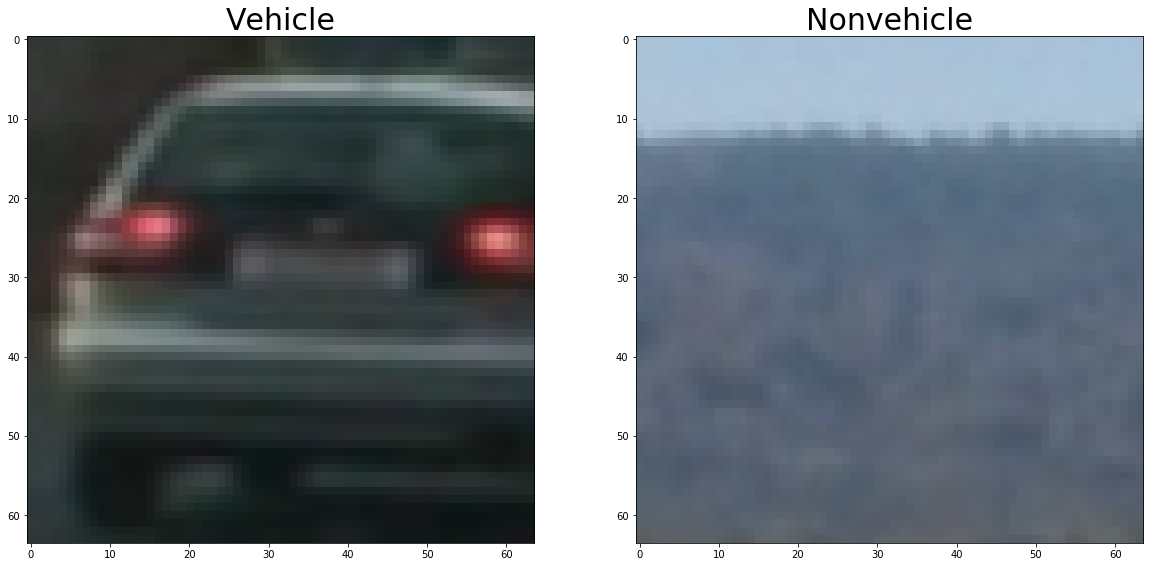

In [1]:
import pickle
import matplotlib.pyplot as plt
data_file = 'data.p'

plt.close()
with open(data_file, mode='rb') as f:
    data = pickle.load(f)
    vehicles_train = data['vehicles_train']
    nonvehicles_train = data['nonvehicles_train']
    vehicles_val = data['vehicles_val']
    nonvehicles_val = data['nonvehicles_val']
    vehicles_test = data['vehicles_test']
    nonvehicles_test = data['nonvehicles_test']

i=100
vehicle = plt.imread(vehicles_train[i])
nonvehicle = plt.imread(nonvehicles_train[i])

font_size=30
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(vehicle)
ax2.imshow(nonvehicle)
ax1.set_title('Vehicle', fontsize=font_size)
ax2.set_title('Nonvehicle', fontsize=font_size)
plt.show()  

## Histogram of Oriented Gradients (HOG)
Extract HOG, spatial and color features.

In [2]:
# User-defined function
from get_features import get_all_features

### Testing on other color space
* YUV
* YCrCB

In [26]:
color_space = 'YCrCb'
data_file = 'data.p'
pickle_file = 'all_feature_YCrCb.p'

if not os.path.exists('all_feature_YCrCb.p'):
    all_reature_dict_YCrCb = get_all_features(data_file, pickle_file, color_space, spatial_size,hist_bins, orient, 
                 pix_per_cell, cell_per_block, hog_channel, 
                 spatial_feat, hist_feat, hog_feat)

else:
    vehicles_train_feat = None
    with open('all_feature_YCrCb.p', mode='rb') as f:
        all_reature_dict_YCrCb = pickle.load(f)
        vehicles_train_feat   = all_reature_dict_YCrCb['vehicles_train_feat']
        nonvehicle_train_feat = all_reature_dict_YCrCb['nonvehicle_train_feat']
        vehicles_val_feat     = all_reature_dict_YCrCb['vehicles_val_feat']
        nonvehicle_val_feat   = all_reature_dict_YCrCb['nonvehicle_val_feat']
        vehicles_test_feat    = all_reature_dict_YCrCb['vehicles_test_feat']
        nonvehicle_test_feat  = all_reature_dict_YCrCb['nonvehicle_test_feat']
        X_scaler              = all_reature_dict_YCrCb['X_scaler']
    if not (vehicles_train_feat is None):
        print("unpacked!")

y_train = np.hstack((np.ones(len(vehicles_train_feat)), np.zeros(len(nonvehicle_train_feat))))
y_val   = np.hstack((np.ones(len(vehicles_val_feat)),   np.zeros(len(nonvehicle_val_feat))))
y_test  = np.hstack((np.ones(len(vehicles_test_feat)),  np.zeros(len(nonvehicle_test_feat))))

X_train = np.vstack((vehicles_train_feat, nonvehicle_train_feat))
X_val   = np.vstack((vehicles_val_feat, nonvehicle_val_feat))
X_test  = np.vstack((vehicles_test_feat, nonvehicle_test_feat))

X_train, y_train = shuffle(X_train,y_train,random_state=1)
X_val, y_val     = shuffle(X_val,y_val,random_state=1)
X_test, y_test   = shuffle(X_test,y_test,random_state=1)

import sklearn.svm as svm
from sklearn.svm import LinearSVC
import time

svc = LinearSVC(C=0.0001)
t=time.time()
svc.fit(X_train, y_train)
print(time.time() - t)
print('Validation Accuracy of SVC = ', round(svc.score(X_val, y_val), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# False Positive
preds = svc.predict(nonvehicle_val_feat)
# find the misclassified images
inds = np.where(preds != np.zeros(len(nonvehicle_val_feat)))
inds = np.ravel(inds)
misclassifieds = [ nonvehicles_val[i] for i in inds]
print('number of false positives',len(misclassifieds))

preds = svc.predict(vehicles_val_feat)
# find the misclassified images
inds = np.where(preds != np.ones(len(vehicles_val_feat)))
inds = np.ravel(inds)
misclassifieds = [ vehicles_val[i] for i in inds]
print('number of false negatives',len(misclassifieds))

unpacked!
2.0993871688842773
Validation Accuracy of SVC =  0.9823
Test Accuracy of SVC =  0.9809
number of false positives 50
number of false negatives 13


In [ ]:
color_space = 'YUV' # not working return error
'''
_hog.py:144: RuntimeWarning: invalid value encountered in sqrt
  image = np.sqrt(image)
'''
data_file = 'data.p'
pickle_file = 'all_feature_YUV.p'
all_reature_dict_YCrCb = get_all_features(data_file, pickle_file, color_space, spatial_size,hist_bins, orient, 
                 pix_per_cell, cell_per_block, hog_channel, 
                 spatial_feat, hist_feat, hog_feat)

vehicles_train_feat   = all_reature_dict_YCrCb['vehicles_train_feat']
nonvehicle_train_feat = all_reature_dict_YCrCb['nonvehicle_train_feat']
vehicles_val_feat     = all_reature_dict_YCrCb['vehicles_val_feat']
nonvehicle_val_feat   = all_reature_dict_YCrCb['nonvehicle_val_feat']
vehicles_test_feat    = all_reature_dict_YCrCb['vehicles_test_feat']
nonvehicle_test_feat  = all_reature_dict_YCrCb['nonvehicle_test_feat']
X_scaler              = all_reature_dict_YCrCb['X_scaler']

y_train = np.hstack((np.ones(len(vehicles_train_feat)), np.zeros(len(nonvehicle_train_feat))))
y_val   = np.hstack((np.ones(len(vehicles_val_feat)),   np.zeros(len(nonvehicle_val_feat))))
y_test  = np.hstack((np.ones(len(vehicles_test_feat)),  np.zeros(len(nonvehicle_test_feat))))

X_train = np.vstack((vehicles_train_feat, nonvehicle_train_feat))
X_val   = np.vstack((vehicles_val_feat, nonvehicle_val_feat))
X_test  = np.vstack((vehicles_test_feat, nonvehicle_test_feat))

X_train, y_train = shuffle(X_train,y_train,random_state=1)
X_val, y_val     = shuffle(X_val,y_val,random_state=1)
X_test, y_test   = shuffle(X_test,y_test,random_state=1)

import sklearn.svm as svm
from sklearn.svm import LinearSVC
import time

svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
print(time.time() - t)
print('Validation Accuracy of SVC = ', round(svc.score(X_val, y_val), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

In [29]:
# Setting parameters:
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (16, 16)
hist_bins = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_feat = True
hist_feat = True
hog_feat = True

# Get alll the features for classification
data_file = 'data.p'
pickle_file = 'all_feature.p'
if not os.path.exists('all_feature.p'):
    all_reature_dict = get_all_features(data_file, pickle_file, color_space, spatial_size,hist_bins, orient, 
                 pix_per_cell, cell_per_block, hog_channel, 
                 spatial_feat, hist_feat, hog_feat)

else:
    vehicles_train_feat = None
    with open('all_feature.p', mode='rb') as f:
        all_reature_dict = pickle.load(f)
        vehicles_train_feat   = all_reature_dict['vehicles_train_feat']
        nonvehicle_train_feat = all_reature_dict['nonvehicle_train_feat']
        vehicles_val_feat     = all_reature_dict['vehicles_val_feat']
        nonvehicle_val_feat   = all_reature_dict['nonvehicle_val_feat']
        vehicles_test_feat    = all_reature_dict['vehicles_test_feat']
        nonvehicle_test_feat  = all_reature_dict['nonvehicle_test_feat']
        X_scaler              = all_reature_dict['X_scaler']
    if not (vehicles_train_feat is None):
        print("unpacked!")

unpacked!


In [30]:
import numpy as np
from sklearn.utils import shuffle
import os.path

if not os.path.exists('ProcessedData.p'):
    y_train = np.hstack((np.ones(len(vehicles_train_feat)), np.zeros(len(nonvehicle_train_feat))))
    y_val   = np.hstack((np.ones(len(vehicles_val_feat)),   np.zeros(len(nonvehicle_val_feat))))
    y_test  = np.hstack((np.ones(len(vehicles_test_feat)),  np.zeros(len(nonvehicle_test_feat))))

    X_train = np.vstack((vehicles_train_feat, nonvehicle_train_feat))
    X_val   = np.vstack((vehicles_val_feat, nonvehicle_val_feat))
    X_test  = np.vstack((vehicles_test_feat, nonvehicle_test_feat))

    X_train, y_train = shuffle(X_train,y_train,random_state=1)
    X_val, y_val     = shuffle(X_val,y_val,random_state=1)
    X_test, y_test   = shuffle(X_test,y_test,random_state=1)
    
    pickle_file = 'ProcessedData.p'
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {
                    'X_train': X_train,
                    'X_val': X_val,
                    'X_test': X_test,
                    'y_train': y_train,
                    'y_val': y_val,
                    'y_test': y_test                
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise
else:
    X_train = None
    with open('ProcessedData.p', mode='rb') as f:
        data = pickle.load(f)
        X_train = data['X_train']
        X_val   = data['X_val']
        X_test  = data['X_test']
        y_train = data['y_train']
        y_val   = data['y_val']
        y_test  = data['y_test']
    if not (X_train is None):
        print("unpacked!")

unpacked!


### Classification using HOG, spatial and color features
I have tried using the rbf kernel for SVM, whis is quite slow and improvement is small, so using the linear SVM intead.

In [52]:
import sklearn.svm as svm
from sklearn.svm import LinearSVC
import time

svc = LinearSVC(C=0.001)
t=time.time()
svc.fit(X_train, y_train)
print(time.time() - t)

4.401902198791504


In [53]:
print('Validation Accuracy of SVC = ', round(svc.score(X_val, y_val), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Validation Accuracy of SVC =  0.9834
Test Accuracy of SVC =  0.9826


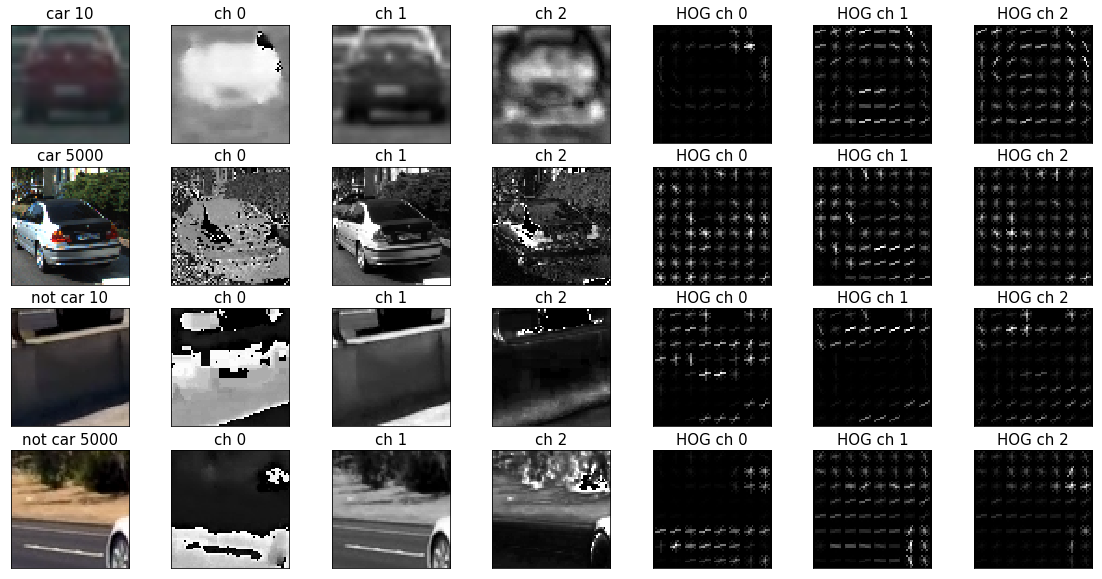

In [49]:
# Show what's going on underneath.
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
from get_features import get_all_features
font_size=15
f, axarr = plt.subplots(4, 7, figsize=(20,10))
f.subplots_adjust(hspace=0.2, wspace=0.05)
colorspace = cv2.COLOR_RGB2HLS
#colorspace=cv2.COLOR_RGB2HSV
#colorspace=cv2.COLOR_RGB2YCrCb

img1, img2= 10,5000

# With vehicle
for ind,j in enumerate([img1, img2]):
    
    image = plt.imread(vehicles_train[j])
    feature_image = cv2.cvtColor(image, colorspace)

    axarr[ind, 0].imshow(image)
    axarr[ind, 0].set_xticks([])
    axarr[ind, 0].set_yticks([])
    title = "car {}".format(j)
    axarr[ind,0].set_title(title, fontsize=font_size)

    for channel in range(3):        
        axarr[ind,channel+1].imshow(feature_image[:,:,channel],cmap='gray')
        title = "ch {}".format(channel)
        axarr[ind,channel+1].set_title(title, fontsize=font_size)
        axarr[ind,channel+1].set_xticks([])
        axarr[ind,channel+1].set_yticks([])    
    
    for channel in range(3):
        features,hog_image = get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, 
                                              cell_per_block, vis=True, feature_vec=True)
        axarr[ind,channel+4].imshow(hog_image,cmap='gray')
        title = "HOG ch {}".format(channel)
        axarr[ind,channel+4].set_title(title, fontsize=font_size)
        axarr[ind,channel+4].set_xticks([])
        axarr[ind,channel+4].set_yticks([])
        
# With nonvehicle        
for indn,j in enumerate([img1, img2]):
    ind=indn+2
    image = plt.imread(nonvehicles_train[j])
    feature_image = cv2.cvtColor(image, colorspace)

    axarr[ind,0].imshow(image)
    axarr[ind,0].set_xticks([])
    axarr[ind,0].set_yticks([])
    title = "not car {}".format(j)
    axarr[ind,0].set_title(title, fontsize=font_size)

    for channel in range(3):        
        axarr[ind,channel+1].imshow(feature_image[:,:,channel],cmap='gray')
        title = "ch {}".format(channel)
        axarr[ind,channel+1].set_title(title, fontsize=font_size)
        axarr[ind,channel+1].set_xticks([])
        axarr[ind,channel+1].set_yticks([])        
    
    for channel in range(3):
        features,hog_image = get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, 
                                              cell_per_block, vis=True, feature_vec=True)
        axarr[ind,channel+4].imshow(hog_image,cmap='gray')
        title = "HOG ch {}".format(channel)
        axarr[ind,channel+4].set_title(title, fontsize=font_size)
        axarr[ind,channel+4].set_xticks([])
        axarr[ind,channel+4].set_yticks([])
        
              
plt.show()

The above figure I showed 4 images from the data of vehicle and nonvehicle. I illustrated that what the features underneath. The original figure is in the frist column, and the next 3 columns are the color channels, and the last 3 columns are the HOG of the each color channel.

---

Next I will show the problem of the SVM with the false positive and false negative results.

number of false positives 38


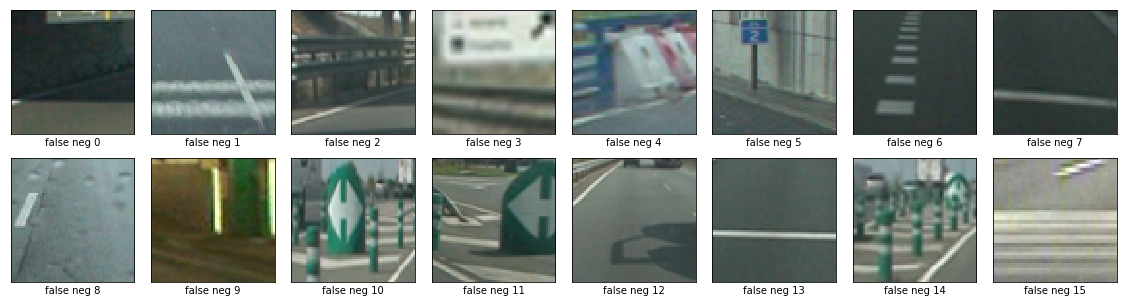

In [54]:
# Plot false positives
font_size=15
preds = svc.predict(nonvehicle_val_feat)
# find the misclassified images
inds = np.where(preds != np.zeros(len(nonvehicle_val_feat)))
inds = np.ravel(inds)
misclassifieds = [ nonvehicles_val[i] for i in inds]

print('number of false positives',len(misclassifieds))
plt.close()

fig, axes = plt.subplots(2, 8,figsize=(20,5))
fig.subplots_adjust(hspace=0.2, wspace=0.05)
    
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(misclassifieds[i]))
    xlabel = "false neg {0}".format(i)
    ax.set_xlabel(xlabel)
    ax.set_xticks([])
    ax.set_yticks([])     
    
plt.show()


number of false negatives 21


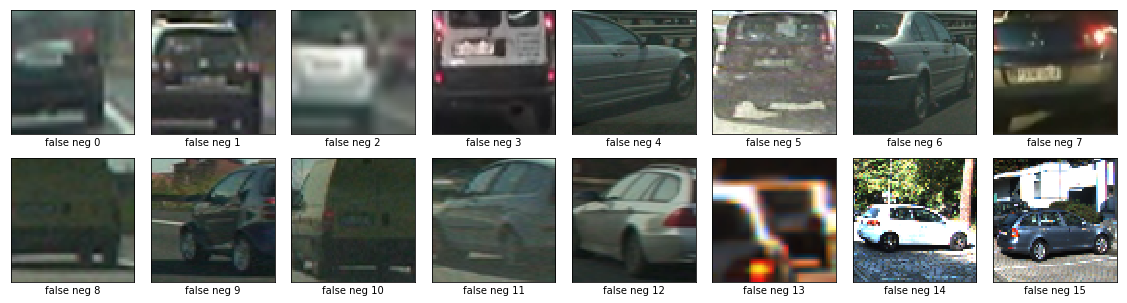

In [55]:
# Plot false negatives
font_size=15
preds = svc.predict(vehicles_val_feat)
# find the misclassified images
inds = np.where(preds != np.ones(len(vehicles_val_feat)))
inds = np.ravel(inds)
misclassifieds = [ vehicles_val[i] for i in inds]
print('number of false negatives',len(misclassifieds))
plt.close()
fig, axes = plt.subplots(2, 8,figsize=(20,5))
fig.subplots_adjust(hspace=0.2, wspace=0.05)
    
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(misclassifieds[i]))
    xlabel = "false neg {0}".format(i)
    ax.set_xlabel(xlabel)
    ax.set_xticks([])
    ax.set_yticks([])     
    

plt.show()

#plt.savefig('./images/false_negatives.png')

In [57]:
# Packup the Classified data
pickle_file = 'ClassifierData.p'
if not os.path.exists(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump(
                {   'svc':svc, 
                    'color_space': color_space,
                    'spatial_size': spatial_size,
                    'hist_bins': hist_bins,
                    'orient': orient,
                    'pix_per_cell': pix_per_cell,
                    'cell_per_block': cell_per_block,
                    'hog_channel': hog_channel,
                    'spatial_feat': spatial_feat,
                    'hist_feat': hist_feat,
                    'hog_feat':hog_feat,
                    'X_scaler': X_scaler
                     
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise
else:
    svc = None
    with open(pickle_file, mode='rb') as f:
        data = pickle.load(f)
        svc = data['svc']
        color_space = data['color_space']
        spatial_size = data['spatial_size']
        hist_bins = data['hist_bins']
        orient = data['orient']
        pix_per_cell = data['pix_per_cell']
        cell_per_block = data['cell_per_block']
        hog_channel = data['hog_channel']
        spatial_feat = data['spatial_feat']
        hist_feat = data['hist_feat']
        hog_feat = data['hog_feat']
        X_scaler = data['X_scaler']
        
    if not (svc is None):
        print("unpacked!")

unpacked!


### Summary 1:
from the above images, you can see, the false positive number is much bigger than the false negative, which I intended to do so. I tweak the parameter to have a low false negative, which when there's is vehicle and the classifier cannot idenfity so. Compare to the false positive, even though it is quite high, this implied my philosophy if my model, better false identify as vehicle when there are, than the opposite. This is the common tradeoff between false pos and neg. When facing a prediction that could lead to accident, I want a low falures. As for the opposite, I don't think it could harm much to "cautiously" predict the opposite.

---

## Slicing Window Search
Similiar to the lecture and the suggestion from the introduction, I segmented image into four zones for the lower half of the image. The windows size are suggested to be 240, 180, 120 and 70 pixels for four zones respectively. The overlapping is 75%, which is the best perform I can get. 

In [37]:
image.shape

(720, 1280, 3)

In [58]:
#set window size:
from window_search import search_all_scales
allwindows  = [(240,240), (180,180), (120,120), (70,70)]
alloverlaps = [(0.75,0.75), (0.75,0.75), (0.75,0.75), (0.75,0.75)]

yi0,yi1,yi2,yi3 = 380,380,395,405                  
Y_pos =[[yi0,yi0+240/2],[yi1,yi1+180/2],[yi2,yi2+120/2],[yi3,yi3+70/2]]

#Y_pos    = [[380,640],[380,600],[380,570],[380,470]]
X_pos    = [[None,None],[None,None],[None,None],[None,None]]
para_path= 'ClassifierData.p'

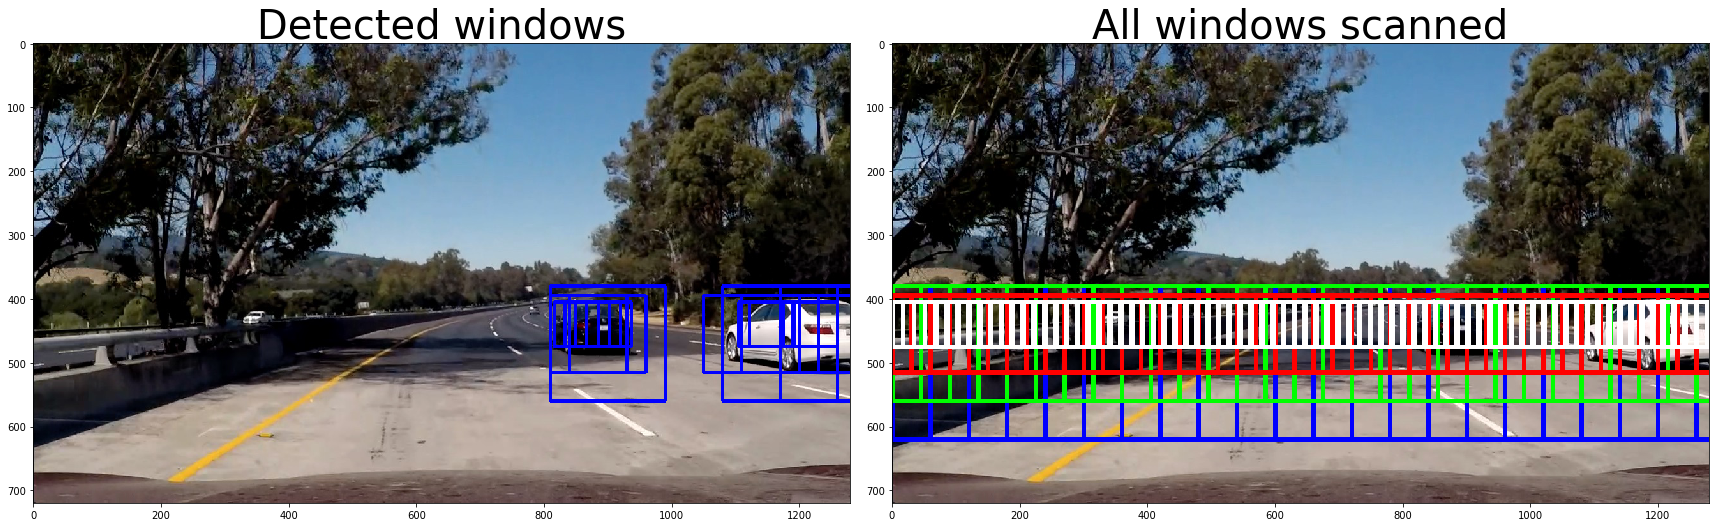

In [59]:
images = glob.glob('test_images/*.jpg')
image_path = images[0]
image = mpimg.imread(image_path)
if image_path.split(".")[-1]=="jpg":
    image = image.astype(np.float32)/255
draw_image = np.copy(image)
jpg = True
hot_windows,all_windows = search_all_scales(para_path, image_path, allwindows, alloverlaps, Y_pos, X_pos, jpg)
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 1), thick=4)  


allwindows_img = draw_image
for ind, win_list in enumerate(all_windows):
    if ind==0: color= (0,0,1)
    if ind==1: color= (0,1,0)
    if ind==2: color= (1,0,0)
    if ind==3: color= (1,1,1)

    allwindows_img = draw_boxes(allwindows_img, all_windows[ind], color=color, thick=6)

        
plt.figure()
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(window_img)
ax1.set_title('Detected windows', fontsize=40)

ax2.imshow(allwindows_img)
ax2.set_title('All windows scanned', fontsize=40)
plt.show()

#     allwindows_img = draw_image
#     for ind,win_list in enumerate(all_windows):
#         if ind==0: color= (0,0,1)
#         if ind==1: color= (0,1,0)
#         if ind==2: color= (1,0,0)
#         if ind==3: color= (1,1,1)
            
#         allwindows_img = draw_boxes(allwindows_img, all_windows[ind], color=color, thick=6)

## Summary 2
From the above results, you can see the windows detection is quite good, and the next step is to testing the model on the video.

## Heatmap Function

In [60]:
# Defind a class for bounding box
# Receive the characteristics of bounding box detections
class BoundingBoxes:
    def __init__(self,n=10):
        # length of queue to store data
        self.n = n
        # hot windows of the last n images
        self.recent_boxes = deque([],maxlen=n)
        # current boxes
        self.current_boxes = None
        self.allboxes = []

    def add_boxes(self):
        self.recent_boxes.appendleft(self.current_boxes)
        
    def pop_data(self):        
        if self.n_buffered>0:
            self.recent_boxes.pop()  
            
    def set_current_boxes(self,boxes):
        self.current_boxes = boxes
        
    def get_all_boxes(self):        
        allboxes = []
        for boxes in self.recent_boxes:
            allboxes += boxes
        if len(allboxes)==0:
            self.allboxes = None
        else:
            self.allboxes = allboxes
            
    def update(self,boxes):
        self.set_current_boxes(boxes)
        self.add_boxes()
        self.get_all_boxes()            

In [61]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    if bbox_list:
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 20)
    # Return the image
    return img


Boxes number is:  15
2 cars found


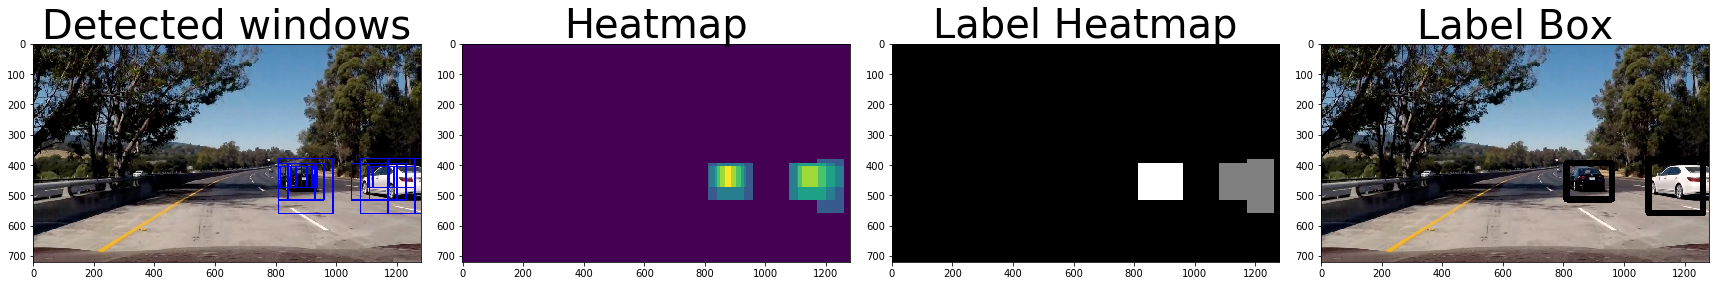

Boxes number is:  13
2 cars found


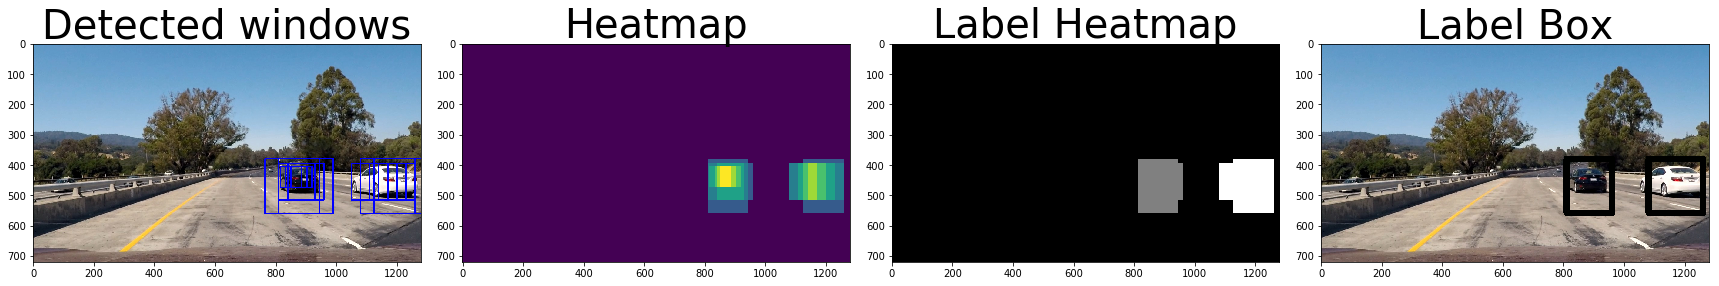

Boxes number is:  7
1 cars found


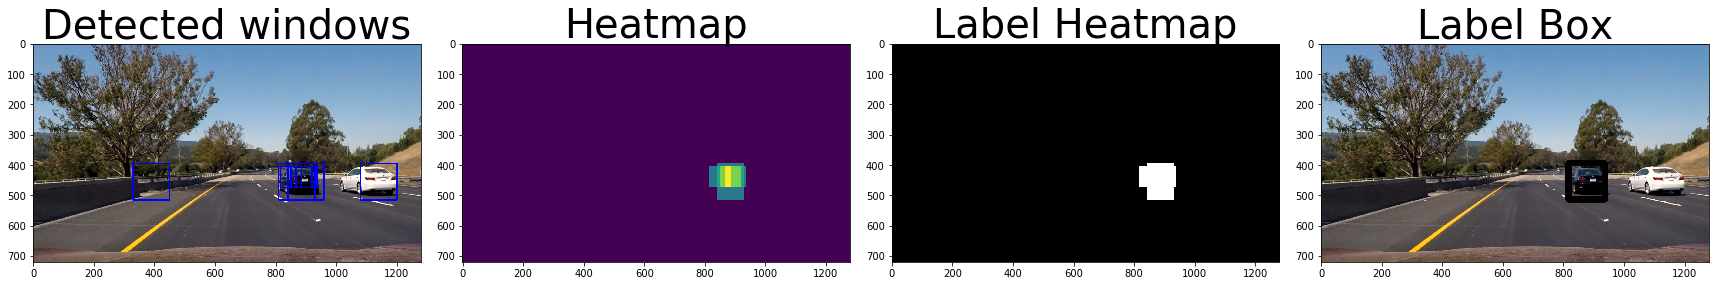

Boxes number is:  0
0 cars found


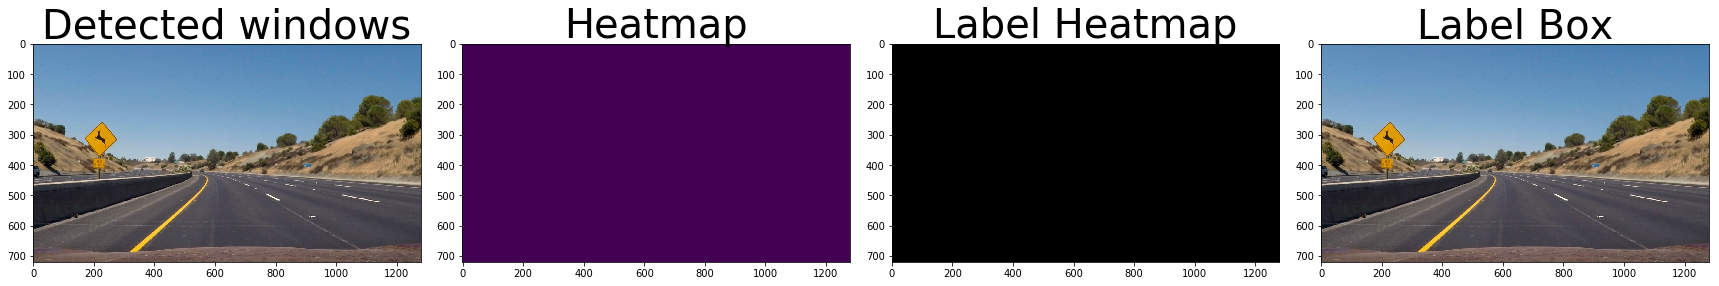

Boxes number is:  5
3 cars found


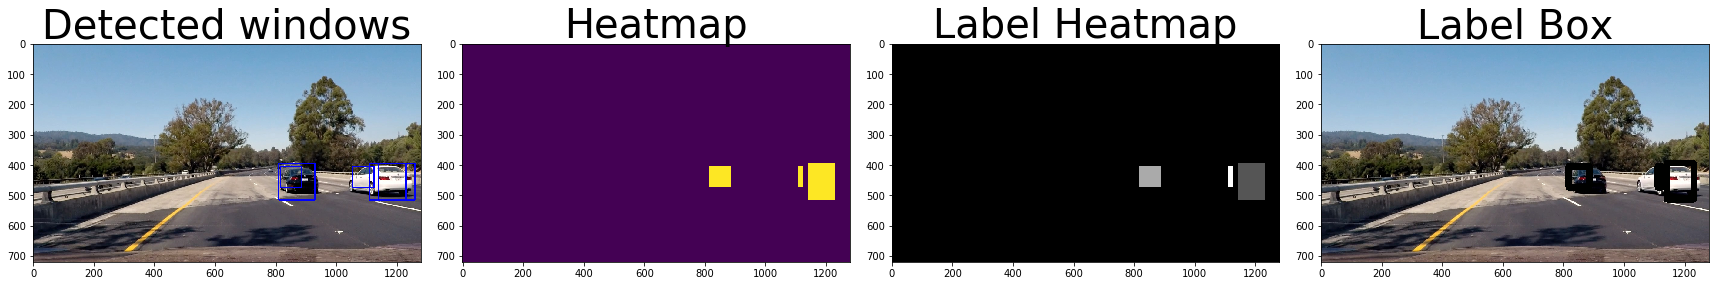

Boxes number is:  2
1 cars found


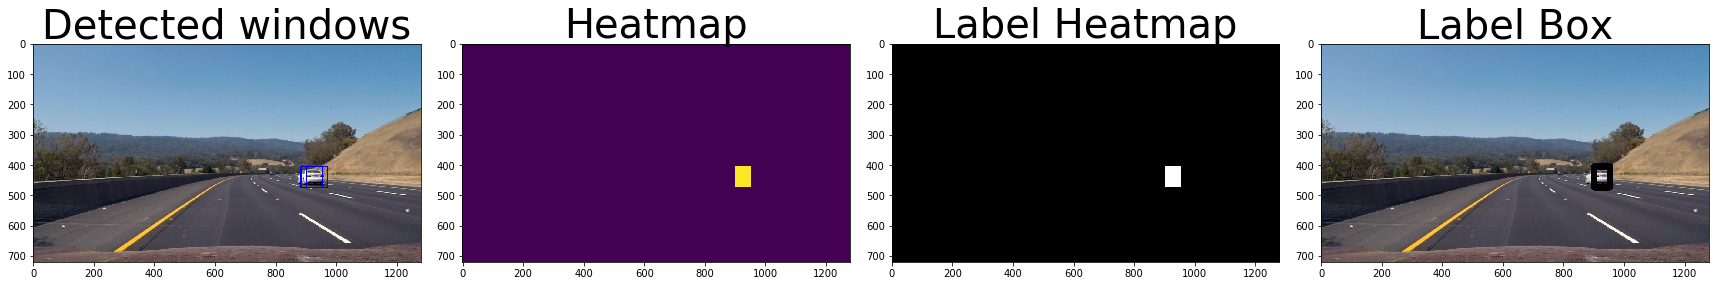

In [9]:
# Testing 
from window_search import search_all_scales
allwindows  = [(240,240), (180,180), (120,120), (70,70)]
alloverlaps = [(0.75,0.75), (0.75,0.75), (0.75,0.75), (0.75,0.75)]
yi0,yi1,yi2,yi3 = 380,380,395,405                  
Y_pos =[[yi0,yi0+240/2],[yi1,yi1+180/2],[yi2,yi2+120/2],[yi3,yi3+70/2]]
X_pos    = [[None,None],[None,None],[None,None],[None,None]]
para_path= 'ClassifierData.p'
box_number = 6
images = glob.glob('./test_images/*.jpg')


for image_path in images:
    boxes = BoundingBoxes(n=box_number)
    image = mpimg.imread(image_path)
    if image_path.split(".")[-1]=="jpg":
        jpg = True
        image = image.astype(np.float32)/255
    
    draw_image = np.copy(image)
    
        
    hot_windows, all_windows = search_all_scales(para_path, image_path, allwindows, alloverlaps, Y_pos, X_pos, jpg)
    
    boxes.update(hot_windows)
    print("Boxes number is: ", len(hot_windows))
    # Draw Detected Image
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 1), thick=4)
    
    # Draw Heatmap Image
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, boxes.allboxes)
    heatmap  = apply_threshold(heatmap, 1)
    
    # Show how many cars are found
    labels = label(heatmap)
    print(labels[1], 'cars found')
    
    # Draw Label image
    label_img = draw_labeled_bboxes(np.copy(image), labels)
    
    plt.figure()    
    f, (ax1,ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 8))
    f.tight_layout()
    ax1.imshow(window_img)
    ax1.set_title('Detected windows', fontsize=40)

    ax2.imshow(heatmap)
    ax2.set_title('Heatmap', fontsize=40)
    
    ax3.imshow(labels[0], cmap='gray')
    ax3.set_title('Label Heatmap', fontsize=40)
    
    ax4.imshow(label_img)
    ax4.set_title('Label Box', fontsize=40)
    plt.show()
    


## Summary 3:
From the above figures, you can tell that the detection job is working, but there's something not as we expected. For example, some of the images have weird lighting, so it's really hard for a simple classifier to handle. I also notice that the power of the model is depends on the the window size, window number, scan region, and threshond of how many boxes overlopping in the heatmap function, I simply used four windows size, it is quite good, with a lot of false positive, which is great from my perspective, better safe than never. I have intend to make the false positive rate high with the trade-off flase negative rate low.

---

## Video Pipeline

In [63]:
boxes = BoundingBoxes(n=30)
def process_image(image):
    from window_search import search_all_scales_video
    
    allwindows  = [(240,240), (180,180), (120,120), (70,70)]
    alloverlaps = [(0.75,0.75), (0.75,0.75), (0.75,0.75), (0.75,0.75)]
    yi0,yi1,yi2,yi3 = 380,380,395,405                  
    Y_pos =[[yi0,yi0+240/2],[yi1,yi1+180/2],[yi2,yi2+120/2],[yi3,yi3+70/2]]
    X_pos    = [[None,None],[None,None],[None,None],[None,None]]
    para_path= 'ClassifierData.p'
    
    
    draw_image = np.copy(image)    
    image = image.astype(np.float32)/255
    hot_windows,_ = search_all_scales_video(para_path, image, allwindows, alloverlaps, Y_pos, X_pos)
    boxes.update(hot_windows)
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, boxes.allboxes)
    heatmap  = apply_threshold(heatmap,15)
    labels = label(heatmap)
    
    window_image = draw_labeled_bboxes(draw_image, labels)
    
    #window_image = draw_boxes(draw_image, hot_windows, color=(0,0,255), thick=6)
    return window_image

In [64]:
out_dir='./'
inpfile='project_video.mp4'
outfile=out_dir+'processed_2_'+inpfile
clip = VideoFileClip(inpfile)
out_clip = clip.fl_image(process_image) 
%time out_clip.write_videofile(outfile, audio=False)

[MoviePy] >>>> Building video ./processed_2_project_video.mp4
[MoviePy] Writing video ./processed_2_project_video.mp4


100%|█████████▉| 1260/1261 [26:16<00:01,  1.29s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./processed_2_project_video.mp4 

CPU times: user 26min 13s, sys: 1.93 s, total: 26min 15s
Wall time: 26min 17s
